
Notebook for playing around with `loseit` weekly summary data

In [1]:
import numpy as np
import datetime as DT
from datetime import date as Date

import scipy.stats as stats
from scipy.optimize import fsolve
from scipy.signal import medfilt
from mealta import data

In [2]:
# -- plotting --
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
loseit = data.Calories()

In [4]:
daily = loseit.daily()

In [5]:
days = [Date.fromisoformat(_date) for _date in daily['date']]

(0.0, 3000.0)

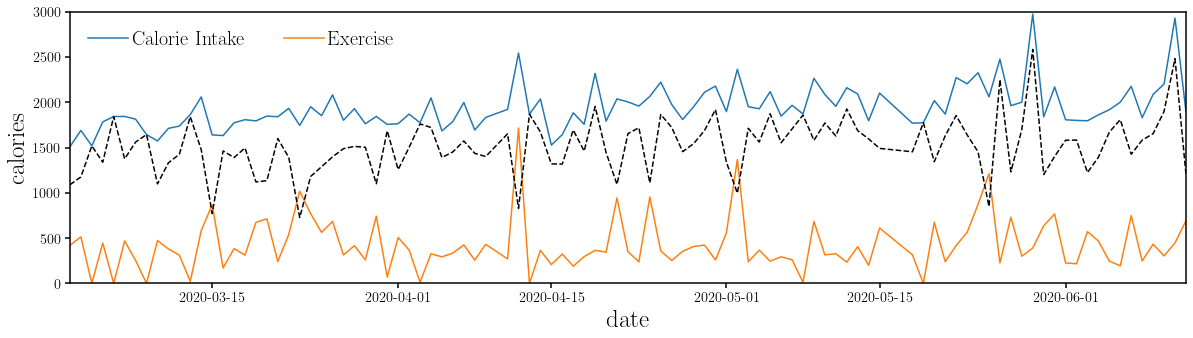

In [54]:
fig = plt.figure(figsize=(20,5))
sub = fig.add_subplot(111)
sub.plot(days, daily['meal'], c='C0', label='Calorie Intake')
sub.plot(days, daily['exercise'], c='C1', label='Exercise')
sub.plot(days, daily['meal'] - daily['exercise'], c='k', ls='--')

sub.legend(loc='upper left', fontsize=20, ncol=2, handletextpad=0.2)
sub.set_xlabel('date', fontsize=25)
sub.set_xlim(days[0], days[-1])
sub.set_ylabel('calories', fontsize=25)
sub.set_ylim(0., 3000)

In [55]:
w_loseit = data.Weights()

In [8]:
weights = w_loseit.read()

In [9]:
days_w = [Date.fromisoformat(_date) for _date in weights['date']]

(150.0, 162.0)

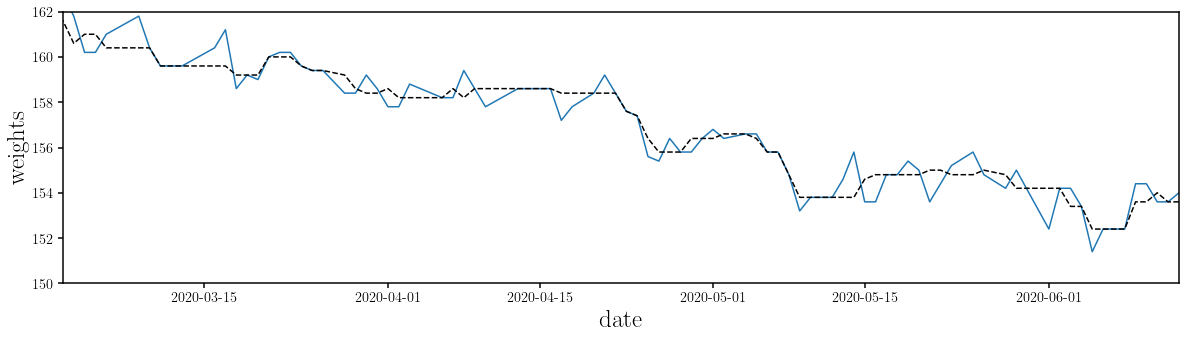

In [10]:
fig = plt.figure(figsize=(20,5))
sub = fig.add_subplot(111)
sub.plot(days_w, weights['weight'], c='C0')
sub.plot(days_w, medfilt(weights['weight'], 5), c='k', ls='--')

sub.set_xlabel('date', fontsize=25)
sub.set_xlim(days[0], days_w[0])
sub.set_ylabel('weights', fontsize=25)
sub.set_ylim(150., 162)

In [11]:
date0 = days[0]

In [12]:
i_days = [(day - date0).days for day in days]
i_days_w = [(Date.fromisoformat(day) - date0).days for day in weights['date']]

In [13]:
def Intake(t): 
    return np.interp(t, i_days, daily['meal'])

def Expenditure(t): 
    return np.interp(t, i_days, daily['exercise'])

def Weights(t):
    return np.interp(t, i_days_w[::-1], medfilt(weights['weight'], 11)[::-1])

In [14]:
def daily_calories_noexercise(t, basal): 
    return Intake(t) - basal

def daily_calories(t, basal, fexp=1.): 
    return Intake(t) - basal - fexp * Expenditure(t)

In [25]:
def BMR(dt=14, t_delay=0, exercise=True, fexp=1.): 
    
    t_basal, basal_metabolism = [], []
    for tt in range(t_delay, len(days)-dt)[::3]: 
        t0 = tt - t_delay
        t_basal.append(date0 + DT.timedelta(t0+0.5*dt))

        dweight = Weights(tt+dt) - Weights(tt)
        dcalories = dweight * 3000.
        
        if not exercise: 
            _fweight = lambda met: np.sum([daily_calories_noexercise(tt, met) for tt in range(t0, t0+dt)]) - dcalories
        else: 
            _fweight = lambda met: np.sum([daily_calories(tt, met, fexp=fexp) for tt in range(t0, t0+dt)]) - dcalories

        basal_metabolism.append(fsolve(_fweight, 2500.)[0])
    return t_basal, basal_metabolism

(0.0, 3000.0)

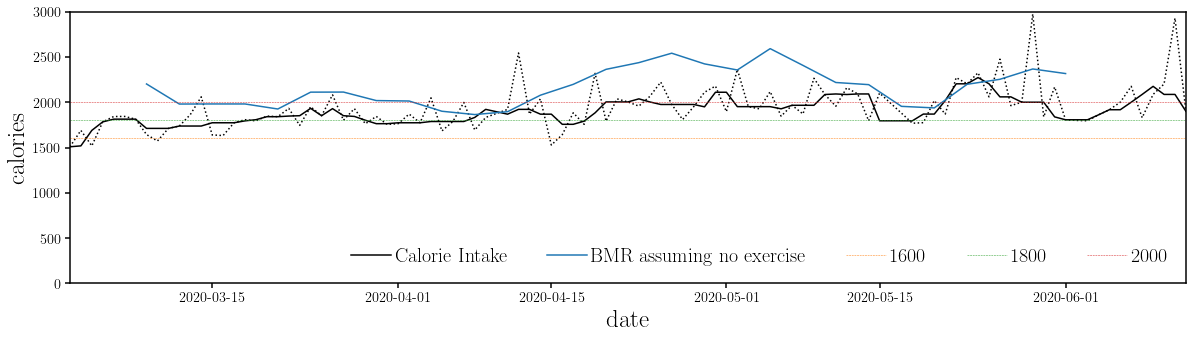

In [56]:
t_bmr, bmr = BMR(dt=14, t_delay=0, exercise=False)

fig = plt.figure(figsize=(20,5))
sub = fig.add_subplot(111)

sub.plot(days, daily['meal'], c='k', ls=':')
sub.plot(days, medfilt(daily['meal'], 5), c='k', label='Calorie Intake')

sub.plot(t_bmr, bmr, label='BMR assuming no exercise')

for cal in [1600., 1800., 2000.]: 
    sub.plot([days[0], days[-1]], [cal, cal], lw=0.5, ls='--', label='%.f' % cal)

sub.legend(loc='lower right', fontsize=20, ncol=5, handletextpad=0.2)
sub.set_xlabel('date', fontsize=25)
sub.set_xlim(days[0], days[-1])
sub.set_ylabel('calories', fontsize=25)
sub.set_ylim(0., 3000)

(0.0, 3000.0)

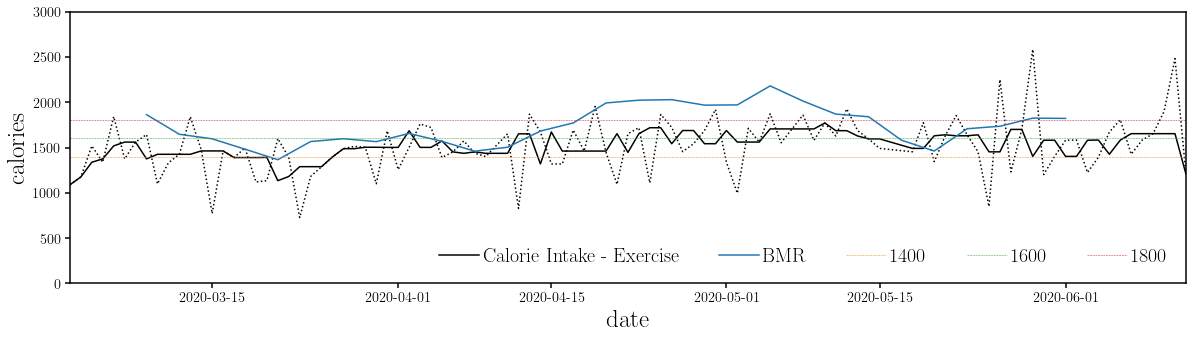

In [57]:
fig = plt.figure(figsize=(20,5))
sub = fig.add_subplot(111)

sub.plot(days, daily['meal'] - daily['exercise'], c='k', ls=':')
sub.plot(days, medfilt(daily['meal'] - daily['exercise'], 5), c='k', label='Calorie Intake - Exercise')


t_bmr, bmr = BMR(dt=14, t_delay=0, exercise=True, fexp=1)
sub.plot(t_bmr, bmr, label='BMR')

for cal in [1400., 1600., 1800.]: 
    sub.plot([days[0], days[-1]], [cal, cal], lw=0.5, ls='--', label='%.f' % cal)

sub.legend(loc='lower right', fontsize=20, ncol=5, handletextpad=0.2)
sub.set_xlabel('date', fontsize=25)
sub.set_xlim(days[0], days[-1])
sub.set_ylabel('calories', fontsize=25)
sub.set_ylim(0., 3000)